# Week 3: CNN Cancer Detection Kaggle Mini-Project

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from PIL import Image

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, BatchNormalization, Activation, Dropout
from keras.optimizers import Adam

import sklearn

## Introduction

In this project, we will use a convolutional neural network(CNN) for cancer detection. The data is provided by a Kaggle Competition,  Histopathologic Cancer Detection (https://www.kaggle.com/competitions/histopathologic-cancer-detection). The main objective of this competition challenge is to identify metastatic cancer in small image patches taken from larger digital pathology scans. The images are stored in the train folder and test folder. The train_labels.csv file provides the truth labels for the images in the train folder. Images with cancer cells are labeled as '1' (positive) and images without cancer cells are labeled '0' (negative). We need to predict the truth labels for the test folder images. According to the Kaggle description, an image is labeled positive if atleast one pixel of cancer cell is detected in the 32x32px center region of the patch. 

The training set contains 220,025 unique images and the test set contains about 57458. Each image file is a .tif file and shape 96x96x3. The '3' refers to the RGB channels.

In [3]:
os.listdir('./histopathologic_cancer_detection/')

['sample_submission.csv', 'test', 'train', 'train_labels.csv']

The image classification tutorial provided by Tensorflow(https://www.tensorflow.org/tutorials/images/classification) suggests using tf.keras.utils.image_dataset_from_directory to efficiently load the data off the disk in a simple way. However, .tif extension is not supported by Tensorflow. So we have to convert the .tif files a tensorflow-supported image format such as .jpg, .png, .bmp. Then we can create a tensorflow dataset from the image files in the directory using tf.keras.utils.image_dataset_from_directory. The API requires the directories to be organized hierarchically with subdirectory to be the name of the class_name or label.

Using the package Pillow, we will convert the TIFF images to .jpg format.

In [4]:
# #Function to convert .tif to .jpg
# #https://www.geeksforgeeks.org/convert-an-image-into-jpg-format-using-pillow-in-python/
def convertImage(newDir, oldDir, fileName):
    targetPath = newDir + fileName[:-4] + ".jpg"
    this_img = Image.open(oldDir + fileName)
    this_img.save(targetPath)
    this_img.close()

In [5]:
# #Make a new directory and subdirectories to store converted images
dir0 = "./hcd/jpgTrain/0/"
dir1 = "./hcd/jpgTrain/1/"
os.makedirs(dir0)
os.makedirs(dir1)

labels_df = pd.read_csv("./histopathologic_cancer_detection/train_labels.csv")
training_labels = list(labels_df.sort_values(by = "id", axis = 0)["label"])

# # Convert all .tif files in "./train/" to .jpg files  
train_dir = "./histopathologic_cancer_detection/train/"
train_imgs = os.listdir(train_dir)
train_imgs.sort()

# #Populate subdirectories 
for i in range(len(train_imgs)):
    if training_labels[i] == 0:
        convertImage(dir0, train_dir, train_imgs[i])
    else:
        assert training_labels[i] == 1
        convertImage(dir1, train_dir, train_imgs[i])

In [6]:
# # Make directories for converted test images. 
dirTest = "./hcd/jpgTest/imgs/"
os.makedirs(dirTest)
test_dir = "./histopathologic_cancer_detection/test/"
test_imgs = os.listdir(test_dir)
test_imgs.sort()

for img in test_imgs:
    convertImage(dirTest, test_dir, img)

In [7]:
print(os.listdir('./hcd/'))
print(os.listdir('./hcd/jpgTrain/'))

['jpgTest', 'jpgTrain']
['0', '1']


In [8]:
print('Number of Images in Train Folder:', len(os.listdir(dir0)) + len(os.listdir(dir1)))
print('Number of Images in Test Folder:', len(os.listdir(dirTest)))

Number of Images in Train Folder: 220025
Number of Images in Test Folder: 57458


Create training and validation datasets using tf.keras.utils.image_dataset_from_directory.

In [9]:
#Train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory = './hcd/jpgTrain/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(96, 96),
  batch_size=32)

Found 220025 files belonging to 2 classes.
Using 176020 files for training.


In [10]:
#Validation dataset
valid_ds = tf.keras.utils.image_dataset_from_directory(
  directory = './hcd/jpgTrain/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(96, 96),
  batch_size=32)

Found 220025 files belonging to 2 classes.
Using 44005 files for validation.


## Exploratory Data Analysis

Now that we processed the data, let's see how the cancerous(1) and non-cancerous(0) labels are distributed. This is to check if the data is balanced.

0    130908
1     89117
Name: label, dtype: int64

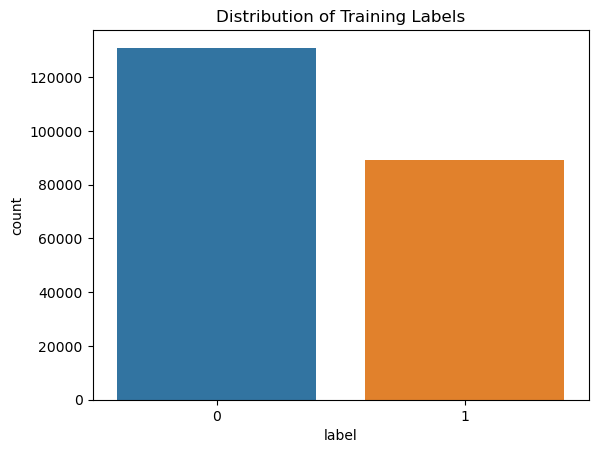

In [11]:
#Plot for training Labels
sns.countplot(data=labels_df, x='label')
plt.title('Distribution of Training Labels')

labels_df['label'].value_counts()

The data seems relatively balanced. Let's view a few images in the training and validation datasets.

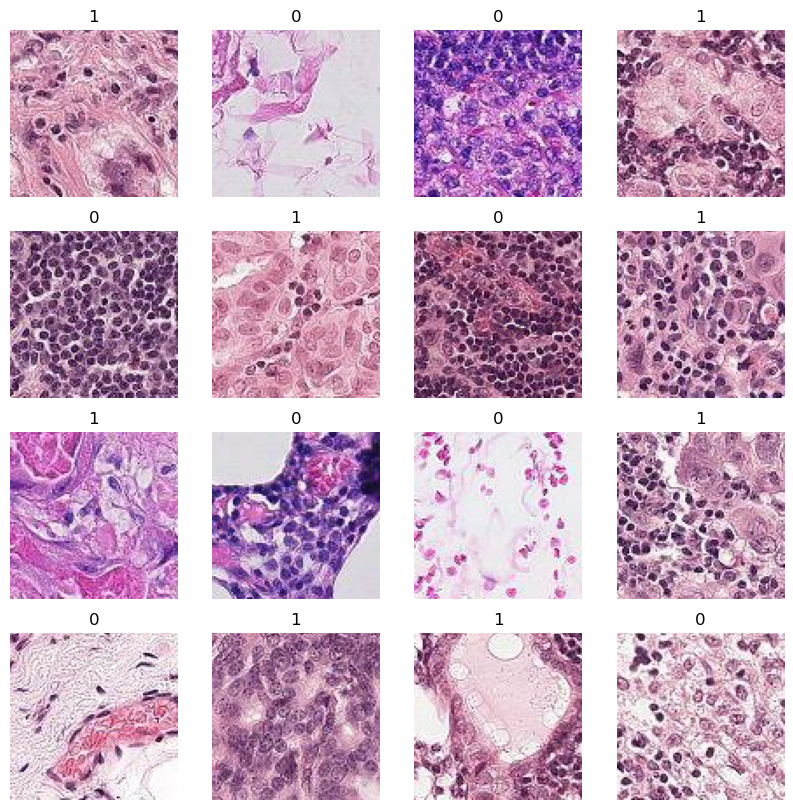

In [13]:
# https://keras.io/examples/vision/image_classification_from_scratch/
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

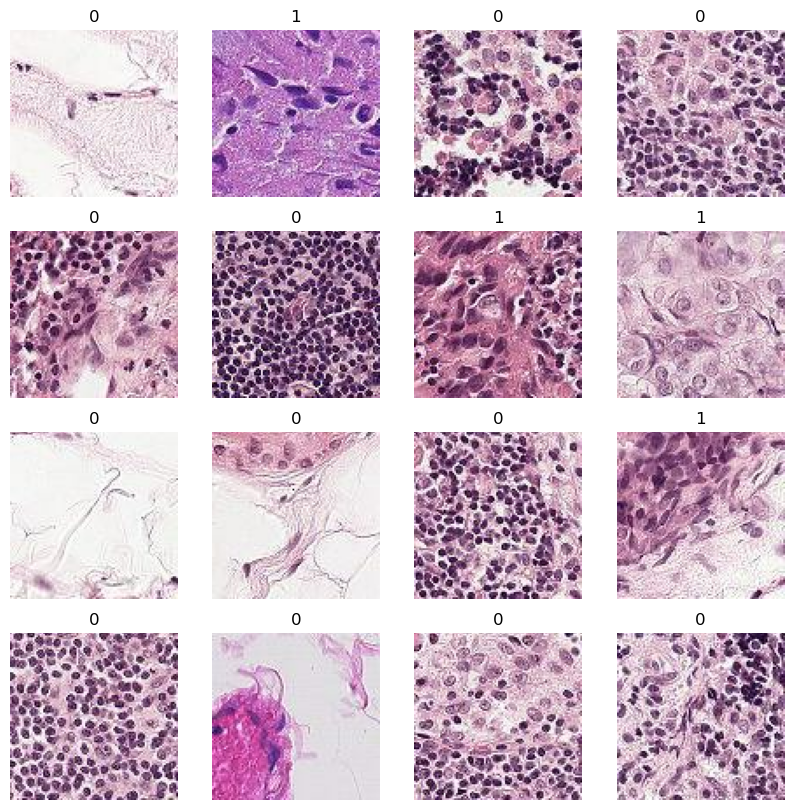

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in valid_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Model Architecture

For the model architecture, I modified the model given in the tensorflow tutorial for image classification. There are 3 Convolution blocks with a MaxPooling layer in each. It is followed by a Dropout layer and two Dense layers. This will be the initial model.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

tr_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
# https://www.tensorflow.org/tutorials/images/classification#create_the_model
#create model
model = Sequential()
model.add(keras.layers.Rescaling(1./255, input_shape = (96, 96, 3)))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

#compile
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

#summarize
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 64)       

In [21]:
epochs=15
callbacks =  [tf.keras.callbacks.EarlyStopping(monitor="loss", patience = 10, mode = "min")]
history = model.fit(train_ds, validation_data = valid_ds, epochs=epochs, callbacks = [callbacks])

Epoch 1/15
5501/5501 [==============================] - 925s 168ms/step - loss: 0.4576 - accuracy: 0.7885 - val_loss: 0.4085 - val_accuracy: 0.8165
Epoch 2/15
5501/5501 [==============================] - 874s 159ms/step - loss: 0.3988 - accuracy: 0.8239 - val_loss: 0.3594 - val_accuracy: 0.8428
Epoch 3/15
5501/5501 [==============================] - 878s 160ms/step - loss: 0.3652 - accuracy: 0.8410 - val_loss: 0.3389 - val_accuracy: 0.8532
Epoch 4/15
5501/5501 [==============================] - 871s 158ms/step - loss: 0.3436 - accuracy: 0.8519 - val_loss: 0.3402 - val_accuracy: 0.8537
Epoch 5/15
5501/5501 [==============================] - 874s 159ms/step - loss: 0.3259 - accuracy: 0.8603 - val_loss: 0.3111 - val_accuracy: 0.8671
Epoch 6/15
5501/5501 [==============================] - 873s 159ms/step - loss: 0.3097 - accuracy: 0.8678 - val_loss: 0.3259 - val_accuracy: 0.8626
Epoch 7/15
5501/5501 [==============================] - 882s 160ms/step - loss: 0.2944 - accuracy: 0.8748 - val_

### Results and Analysis

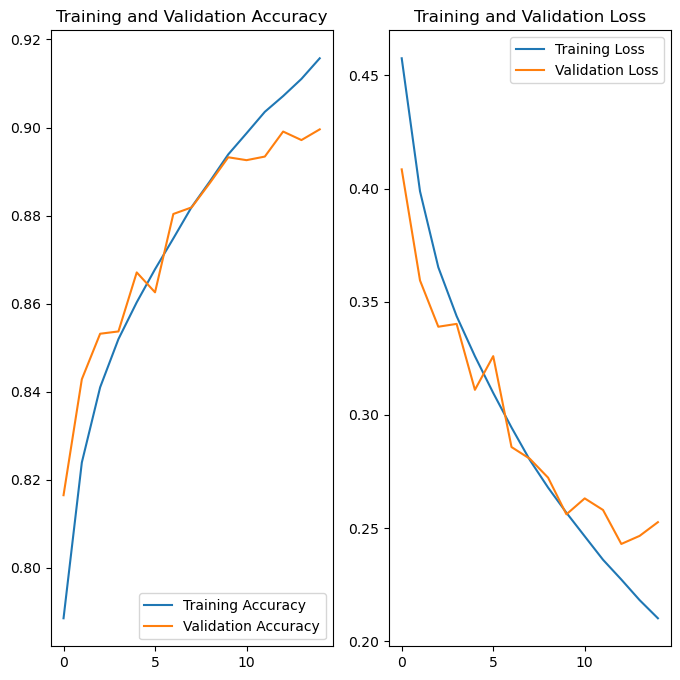

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Commentary

The initial model seems to do quite well. The Validation accuracy seems to follow the training accuracy. Now we will see if we can improve the model with hyperparameter training.

## Hyperparameter Tuning

For hyperparameter tuning, I've experimented with various number of filters in the convolution layer. I've also tested different values for Dropout layer and number of units in the first Dense layer. I've also chosen different learning rate values between (1e-3, 2e-4).

In [27]:
#create model
model2 = Sequential()
model2.add(keras.layers.Rescaling(1./255, input_shape = (96, 96, 3)))

model2.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size = 2))

model2.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size = 2))

model2.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size = 2))

model2.add(Dropout(0.1))
model2.add(Flatten())
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

#compile
model2.compile(optimizer=Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])

#summarize
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 64)       

In [31]:
hist = model2.fit(train_ds, validation_data = valid_ds, epochs=10, callbacks = [callbacks])

Epoch 1/10
5501/5501 [==============================] - 1108s 201ms/step - loss: 0.2462 - accuracy: 0.8992 - val_loss: 0.2517 - val_accuracy: 0.8971
Epoch 2/10
5501/5501 [==============================] - 964s 175ms/step - loss: 0.2259 - accuracy: 0.9086 - val_loss: 0.2888 - val_accuracy: 0.8861
Epoch 3/10
5501/5501 [==============================] - 872s 159ms/step - loss: 0.2086 - accuracy: 0.9169 - val_loss: 0.2581 - val_accuracy: 0.8932
Epoch 4/10
5501/5501 [==============================] - 880s 160ms/step - loss: 0.1902 - accuracy: 0.9250 - val_loss: 0.2405 - val_accuracy: 0.9033
Epoch 5/10
5501/5501 [==============================] - 973s 177ms/step - loss: 0.1748 - accuracy: 0.9314 - val_loss: 0.2450 - val_accuracy: 0.9023
Epoch 6/10
5501/5501 [==============================] - 1117s 203ms/step - loss: 0.1589 - accuracy: 0.9383 - val_loss: 0.2406 - val_accuracy: 0.9061
Epoch 7/10
5501/5501 [==============================] - 983s 179ms/step - loss: 0.1443 - accuracy: 0.9443 - va

### Results and Analysis

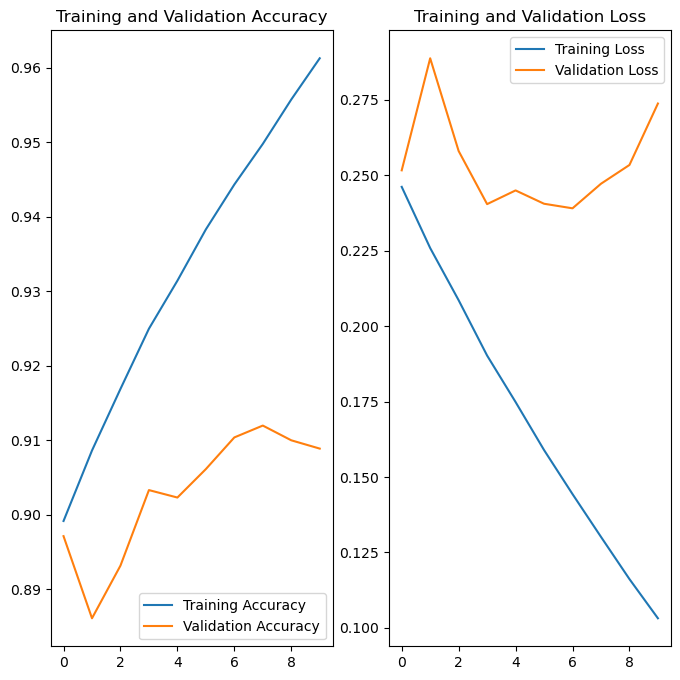

In [33]:
acc2 = hist.history['accuracy']
val_acc2 = hist.history['val_accuracy']

loss2 = hist.history['loss']
val_loss2 = hist.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Commentary

This model seems to improve from the initial model. Although the validation accuracy doesn't follow the training accuracy, it is still higher than the previous model. The validation and training loss in this model are lower than the previous model.

In [39]:
#create model
model3 = Sequential()
model3.add(keras.layers.Rescaling(1./255, input_shape = (96, 96, 3)))

model3.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model3.add(MaxPooling2D(pool_size = 2))

model3.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model3.add(MaxPooling2D(pool_size = 2))

model3.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model3.add(MaxPooling2D(pool_size = 2))

model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(256, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))

#compile
model3.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

#summarize
model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 96, 96, 3)         0         
                                                                 
 conv2d_30 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 24, 24, 64)      

In [41]:
hist_ = model3.fit(train_ds, validation_data = valid_ds, epochs=10, callbacks = [callbacks])

Epoch 1/10
5501/5501 [==============================] - 886s 161ms/step - loss: 0.2469 - accuracy: 0.8988 - val_loss: 0.2418 - val_accuracy: 0.9044
Epoch 2/10
5501/5501 [==============================] - 894s 163ms/step - loss: 0.2279 - accuracy: 0.9080 - val_loss: 0.2382 - val_accuracy: 0.9066
Epoch 3/10
5501/5501 [==============================] - 1019s 185ms/step - loss: 0.2098 - accuracy: 0.9163 - val_loss: 0.2409 - val_accuracy: 0.9052
Epoch 4/10
5501/5501 [==============================] - 902s 164ms/step - loss: 0.1913 - accuracy: 0.9238 - val_loss: 0.2597 - val_accuracy: 0.9015
Epoch 5/10
5501/5501 [==============================] - 898s 163ms/step - loss: 0.1732 - accuracy: 0.9319 - val_loss: 0.2761 - val_accuracy: 0.8978
Epoch 6/10
5501/5501 [==============================] - 1029s 187ms/step - loss: 0.1543 - accuracy: 0.9396 - val_loss: 0.2531 - val_accuracy: 0.9050
Epoch 7/10
5501/5501 [==============================] - 1032s 188ms/step - loss: 0.1410 - accuracy: 0.9453 - v

### Results and Analysis

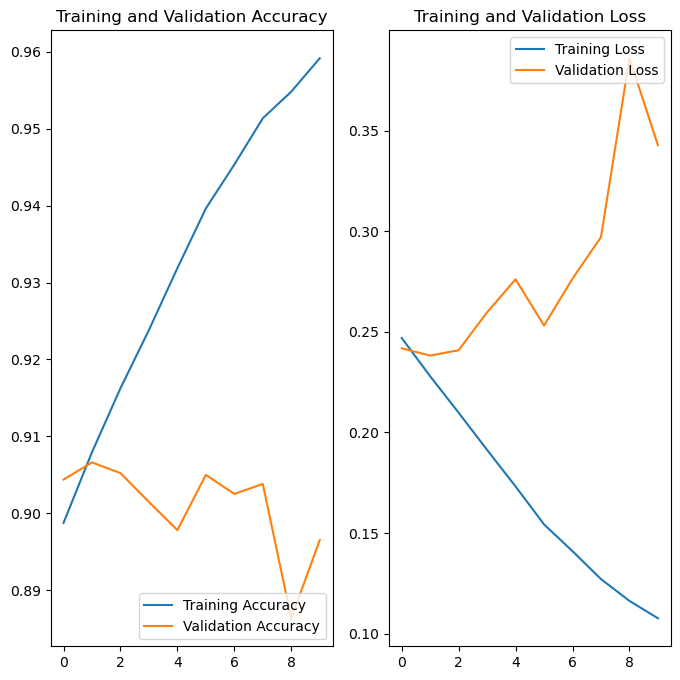

In [42]:
acc3 = hist_.history['accuracy']
val_acc3 = hist_.history['val_accuracy']

loss3 = hist_.history['loss']
val_loss3 = hist_.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc3, label='Training Accuracy')
plt.plot(epochs_range, val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss3, label='Training Loss')
plt.plot(epochs_range, val_loss3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Commentary

The third model isn't better than the second model, however it is better than the initial model. The validation accuracy is slightly less than the previous model, but this model has higher validation loss values.

## Test Data Submission

In [114]:
#Test Dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  directory = './hcd/jpgTest/',
  seed=123,
  image_size=(96, 96),
  batch_size=32)

Found 57458 files belonging to 1 classes.


In [118]:
yhat = model3.predict(test_ds)

1796/1796 [==============================] - 95s 53ms/step


In [119]:
predictions = []

for pred in yhat:
    if pred >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

In [120]:
testids = test_ds.file_paths
id = [testids[i][19 :-4] for i in range(len(testids))]
submission = pd.DataFrame()
submission = {
    "id" : id,
    "label" : predictions
}

submission_df = pd.DataFrame(submission)

In [121]:
submission_df['id'].value_counts()

5200faaebbc40a33daed862aa1685e9b460e2f7b    1
647ab802c67c67bc64f63c2b055fcc5fbbc90798    1
d6bb9eb59eb5200aa5ac559ffb24204df6815cc3    1
12ac8230bcd1d6534b5a21b8de66303053c65ffb    1
99f7c508425b3e8311d60827bb41fc384a822a8d    1
                                           ..
f0d351ff23f08bcb1c5e2e7bbfda39ac91309712    1
dc0bb4ebd29882368f9e1d5c46dc51ab2d4b81d8    1
7e43b15f9b04dfa36a80ffc8787a2115fe3633df    1
b0b8dc44aebac0c78a83dd73274d3ec131f45b34    1
eb043fc7a08b0a0748491f309beb693803e8d6a5    1
Name: id, Length: 57458, dtype: int64

In [122]:
unique_counts = submission_df['label'].value_counts()
print(unique_counts)

0    39663
1    17795
Name: label, dtype: int64


In [123]:
submission_df.to_csv('submission.csv', index=False)

## Conclusion

In this project, we built a convolutional neural network model to detect metastatic cancer cells in small image patches. The tensorflow tutorial on image classification was a great starting point for me, being new to Deep Learning, Tensorflow and Keras. 

The initial model did better on the test data than the other two models, however the accuracy was only 50%. The training for each model build took a very long time, even with less number of epochs. After hyperparameter tuning, the two other models seemed to be better, but they didn't perform well on the test data. 

In future work, I would like to experiment with adding more convolutional layers to each block in the model and train the model using GPU or TPU so that training can be done faster.

## References

1. https://www.tensorflow.org/tutorials/images/classification
2. https://www.geeksforgeeks.org/convert-an-image-into-jpg-format-using-pillow-in-python/
3. https://keras.io/examples/vision/image_classification_from_scratch/
4. https://www.kaggle.com/code/vbookshelf/cnn-how-to-use-160-000-images-without-crashing
5. https://www.kaggle.com/code/lorbybi/cnn-histopathologic-cancer-detection